In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from scipy.signal.windows import *

In [4]:
torch.cuda.set_device(0)

Kaggle Dog Breed Identification. Get data from https://www.kaggle.com/c/dog-breed-identification

In [5]:
PATH = "data/"
sz = 224
arch = resnext50
bs = 52

In [11]:
label_csv = f'{PATH}y3.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n, val_pct=0.2, seed=41) # random 20% data for validation set

In [12]:
#val_idxs = np.arange(int(n*.8), n)

In [13]:
n

15210

In [14]:
len(val_idxs)

3042

In [15]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'vidya/person', f'{PATH}y3.csv', # we need to specify where the test set is if you want to submit to Kaggle competitions
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

['class_1', 'class_10', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6', 'class_7', 'class_8', 'class_9']
[1 1 1 ... 1 1 1]


In [16]:
freq = Counter(data.trn_ds.y)

In [17]:
weights = []

In [18]:
total_len = len(data.trn_ds.y)

In [19]:
total_len

12168

In [20]:
for i in range(10):
    weights.append(total_len/freq[i])

In [21]:
weights

[88.17391304347827,
 1.1750845002414292,
 74.65030674846626,
 95.81102362204724,
 60.23762376237624,
 43.457142857142856,
 45.57303370786517,
 68.35955056179775,
 51.34177215189873,
 55.05882352941177]

In [22]:
fn = PATH + data.trn_ds.fnames[0]; fn

'data/vidya/person/0.jpg'

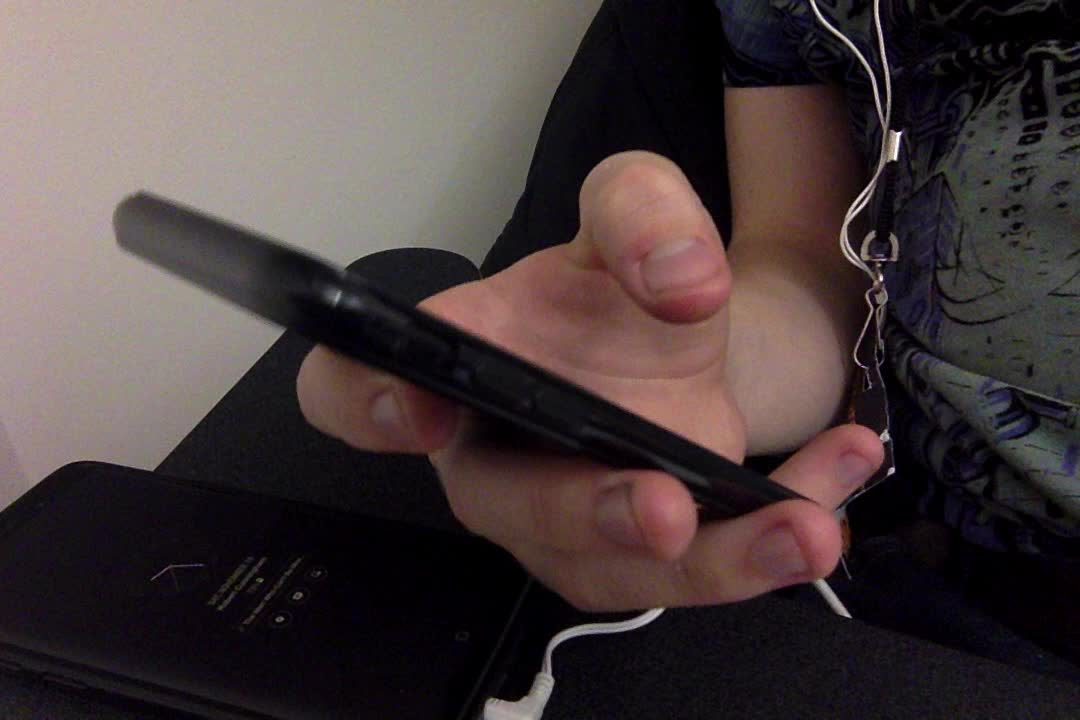

In [23]:
img = PIL.Image.open(fn); img

In [24]:
img.size

(1080, 720)

In [25]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [26]:
row_sz, col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [ ]:
row_sz[:5]

In [ ]:
len(data.trn_ds)#, len(data.test_ds)

In [ ]:
len(data.classes), data.classes[:5]

## Initial model

In [ ]:
def get_data(sz, bs): # sz: image size, bs: batch size
    tmfs = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'vidya/person', f'{PATH}y3.csv',
                                       val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
    
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/13
    # http://forums.fast.ai/t/how-to-train-on-the-full-dataset-using-imageclassifierdata-from-csv/7761/37
    return data if sz > 300 else data.resize(340, 'tmp') # Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time

#Source:   
#    def resize(self, targ, new_path):
#        new_ds = []
#        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
#        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
#        else: dls += [None,None]
#        t = tqdm_notebook(dls)
#        for dl in t: new_ds.append(self.resized(dl, targ, new_path))
#        t.close()
#        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)
#File:      ~/fastai/courses/dl1/fastai/dataset.py

In [ ]:
data.trn_ds.get_y(10)

### Precompute

In [ ]:
data = get_data(sz, bs)

In [ ]:
weight = torch.Tensor(np.array(weights)).cuda()

In [ ]:
def fake_crit(a, b):
    return F.nll_loss(a, b, weight=weight)

In [ ]:
learn = ConvLearner.pretrained(arch, data, precompute=False, crit=fake_crit)

In [ ]:
#learn.lr_find()

In [ ]:
#learn.sched.plot()

In [ ]:
learn.fit(1e-2, cycle_len=5, n_cycle=1)

In [ ]:
torch.save(learn.model.state_dict(), 'state_dict')

In [ ]:
data.val_ds.is_multi

In [ ]:
preds = learn.predict_dl(data.val_dl)

In [ ]:
ys = data.val_ds.y; ys.shape

In [ ]:
preds = np.exp(preds)

In [ ]:
ys

In [ ]:
np.argmax(preds, axis=1)

In [ ]:
plt.plot(preds)

In [ ]:
preds.shape

In [ ]:
taps = np.sort(np.where(np.argsort(preds[:, 1]) < 4))[0]

In [ ]:
out = np.array([preds[x] for x in taps]); np.product(out[:, 0])

In [ ]:
out[-1] = 100

In [ ]:
pin_freq_list = list()
pin_list = list()
with open('4digit_pin_probabilities.csv') as csv_file:
        pin_frequencies = csv.reader(csv_file, delimiter=',')
        for row in pin_frequencies:
            pin_freq_list.append(float(row[1]))
            pin_list.append(row[0])

In [ ]:
pin_freq_list

In [ ]:
def final_prediction(predicted_probabilities):
    freq_matrix = np.asarray(predicted_probabilities)
    prob_list = list()
    for i in range(0,10):
        for j in range(0,10):
            for k in range(0, 10):
                for l in range(0, 10):
                    prob_list.append(freq_matrix[0, i]*freq_matrix[1, j]*freq_matrix[2, k]*freq_matrix[3, l])
    prob_vector = np.asarray(prob_list)
    
    pin_freq_list = list()
    
    pin_list = list()
        
    with open('4digit_pin_probabilities.csv') as csv_file:
        pin_frequencies = csv.reader(csv_file, delimiter=',')
        for row in pin_frequencies:
            pin_freq_list.append(float(row[1]))
            pin_list.append(row[0])
    freq_vector = np.asarray(pin_freq_list)
    
    print(freq_vector)
    print(prob_vector**2*10000)
    print(freq_vector[1234])
    
    final_probabilties = freq_vector * prob_vector
    
    pin_array = np.asarray(pin_list)
    
    max_indices = np.argpartition(final_probabilties, -5)[-5:]
    top_5_pins = [pin_array[i] for i in range(len(max_indices))]
    return top_5_pins, freq_matrix

In [ ]:
final_prediction([list(preds[x]) for x in taps])

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline